<a href="https://colab.research.google.com/github/flying-bear/ANLPotsdam/blob/master/Word2sent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [1]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5MB 5.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
!pip install pymystem3==0.1.10

  Attempting uninstall: pymystem3
    Found existing installation: pymystem3 0.2.0
    Uninstalling pymystem3-0.2.0:
      Successfully uninstalled pymystem3-0.2.0


In [3]:
!pip install simple-elmo

In [4]:
! pip install tensorflow==2.4.1

In [5]:
!pip install git+https://github.com/deepmipt/deepPavlovEval

  Cloning https://github.com/deepmipt/deepPavlovEval to /tmp/pip-req-build-tp0m6aac
  Running command git clone -q https://github.com/deepmipt/deepPavlovEval /tmp/pip-req-build-tp0m6aac
     |████████████████████████████████| 988 kB 5.7 MB/s 
     |████████████████████████████████| 52 kB 749 kB/s 
     |████████████████████████████████| 144 kB 12.7 MB/s 
     |████████████████████████████████| 17.2 MB 145 kB/s 
     |████████████████████████████████| 253.2 MB 16 kB/s 
     |████████████████████████████████| 566 kB 78.3 MB/s 
     |████████████████████████████████| 12.2 MB 81.9 MB/s 
     |████████████████████████████████| 3.3 MB 59.4 MB/s 
     |████████████████████████████████| 46 kB 3.1 MB/s 
     |████████████████████████████████| 40 kB 20 kB/s 
     |████████████████████████████████| 510 kB 43.0 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.5 MB 56.7 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 
     |███████

In [6]:
!pip install deeppavlov

In [7]:
!pip install tensorflow --upgrade --force-reinstall

     |████████████████████████████████| 394.3 MB 19 kB/s 
     |████████████████████████████████| 462 kB 53.4 MB/s 
     |████████████████████████████████| 3.8 MB 32.4 MB/s 
     |████████████████████████████████| 14.8 MB 257 kB/s 
     |████████████████████████████████| 10.6 MB 40.2 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 57 kB 5.0 MB/s 
     |████████████████████████████████| 2.9 MB 64.3 MB/s 
     |████████████████████████████████| 127 kB 67.9 MB/s 
     |████████████████████████████████| 1.0 MB 58.1 MB/s 
     |████████████████████████████████| 96 kB 5.1 MB/s 
     |████████████████████████████████| 298 kB 61.4 MB/s 
     |████████████████████████████████| 784 kB 44.9 MB/s 
     |████████████████████████████████| 135 kB 78.8 MB/s 
     |████████████████████████████████| 781 kB 69.4 MB/s 
     |████████████████████████████████| 61 kB 7.6 MB/s 
     |█████████████████

In [8]:
!pip install gensim==3.8.0

     |████████████████████████████████| 24.2 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 2.3.0
    Uninstalling gensim-2.3.0:
      Successfully uninstalled gensim-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeppavloveval 0.1 requires gensim==2.3.0, but you have gensim 3.8.0 which is incompatible.


### Imports

In [9]:
import deeppavlov
import numpy as np
import nltk
import pandas as pd
import pickle

from deepPavlovEval import datautils
from deeppavlov.dataset_readers.paraphraser_reader import ParaphraserReader
from gensim.models.keyedvectors import  KeyedVectors, FastTextKeyedVectors
from gensim.test.utils import datapath
from collections import Counter
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from scipy.stats import pearsonr
from simple_elmo import ElmoModel
from sklearn.decomposition import TruncatedSVD
from string import punctuation
from tqdm import tqdm_notebook

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Initializations

In [211]:
mystem_analyzer = Mystem()  # initialize lemmatizer / POS analyzer
# tqdm_notebook().pandas(*args, **kwargs)
flatten = lambda l: [item for sublist in l for item in sublist]  # generally handy function

Common preprocessing

In [12]:
def tokenize(text):
    tokens = word_tokenize(text.lower())
    return [token for token in tokens if token != " " and token.strip() not in punctuation + '«»']

In [13]:
def cos_sim(v1, v2):
    return np.inner(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

# 1. Set up word vectors

## 1.1. Skipgram
Note that the model uses Universal Dependency POS tags and we need to attach the tags to look up the words in the model

### 1.1.1. Load the model

In [14]:
!wget http://vectors.nlpl.eu/repository/20/185.zip 
!unzip 185.zip -d /185

--2021-02-20 17:09:29--  http://vectors.nlpl.eu/repository/20/185.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 639268566 (610M) [application/zip]
Saving to: ‘185.zip’

185.zip             100%[===================>] 609.65M  23.5MB/s    in 27s     

2021-02-20 17:09:56 (22.5 MB/s) - ‘185.zip’ saved [639268566/639268566]

Archive:  185.zip
  inflating: /185/meta.json          
  inflating: /185/model.bin          
  inflating: /185/model.txt          
  inflating: /185/README             


In [15]:
skipgram_model = KeyedVectors.load_word2vec_format('/185/model.bin', binary=True)

In [16]:
skipgram_model['сок_NOUN']

array([-0.08099871, -0.07964684,  0.14386585, -0.43131432,  0.20225914,
       -0.07856081, -0.44900608, -0.04367054,  0.09742382, -0.4288675 ,
       -0.6394641 , -0.36070755,  0.24424982, -0.17829788, -0.22998579,
        0.32191253,  0.08742036,  0.16346864,  0.20877619,  0.09263267,
       -0.07815196, -0.29388112,  0.13611834,  0.528291  ,  0.06399126,
        0.11340062,  0.5236766 ,  0.14278895, -0.28039816,  0.2727956 ,
       -0.20747079, -0.2084978 ,  0.07029346, -0.45236102,  0.13124529,
       -0.31452668, -0.3109191 ,  0.19610703,  0.0846853 ,  0.25168318,
        0.6365907 ,  0.4371937 , -0.19672993, -0.38342577, -0.14342354,
        0.02790144,  0.1147646 , -0.0919205 , -0.3337107 , -0.2234547 ,
       -0.0123342 ,  0.00343434,  0.02184114,  0.05203297,  0.10262688,
       -0.68969965,  0.07867927,  0.60214436,  0.27626538, -0.18604952,
        0.04802926,  0.15835124,  0.2553374 ,  0.29401794,  0.34163678,
        0.12013741, -0.09235196, -0.3989918 , -0.2011238 , -0.30

### 1.1.2. Preprocessing: lemmatization + get the correct POS tags

In [17]:
# translation from Mystem POS tags to UD POS tags
!wget https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map

--2021-02-20 17:10:16--  https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4093 (4.0K) [text/plain]
Saving to: ‘ru-rnc.map’

ru-rnc.map          100%[===================>]   4.00K  --.-KB/s    in 0s      

2021-02-20 17:10:16 (64.0 MB/s) - ‘ru-rnc.map’ saved [4093/4093]



In [18]:
translate_POS = {}
with open('ru-rnc.map', 'r') as f:
  for line in f.readlines():
    Mystem_POS, UD_POS = line.split()
    translate_POS[Mystem_POS] = UD_POS

In [19]:
ex_text = 'я хочу спать'.split()
# mystem_analyzer.analyze(word) for word in sent
# [{'gr': 'SPRO,ед,1-л=им', 'lex': 'я', 'wt': 0.9999716282},
#  {'gr': 'V,несов,пе=непрош,ед,изъяв,1-л', 'lex': 'хотеть', 'wt': 1},
#  {'gr': 'V,несов,нп=инф', 'lex': 'спать', 'wt': 1}]

In [20]:
[mystem_analyzer.analyze(word) for word in ex_text][0]

[{'analysis': [{'gr': 'SPRO,ед,1-л=им', 'lex': 'я', 'wt': 0.9999716282}],
  'text': 'я'},
 {'text': '\n'}]

In [21]:
def get_UDPOS(sent):
  """
  lemmatizes and attaches UD POS tags to words in a sentence
  !!! uses global translate_POS and mystem_analyzer

  :input sent: list of str, sentence to lemmatize and POS-tag
  :return: list of str, lemmas with POS UD tags
  """
  analysis = []
  for word in sent:
    word_analysis = mystem_analyzer.analyze(word)[0]
    if 'analysis' in word_analysis and len(word_analysis['analysis']) > 0:
      analysis.append(word_analysis['analysis'][0])
    else:
      analysis.append('placeholder')

  lex_mystem = []
  for word_analysis in analysis:
    if 'lex' and 'gr' in word_analysis:
      lex_mystem.append((word_analysis['lex'], word_analysis['gr'].split(',')[0]))
    else:
      lex_mystem.append(('placeholder',''))

  POSd = []
  for word_analysis in lex_mystem:
    if word_analysis[1] in translate_POS:
      POSd.append(word_analysis[0] + '_' + translate_POS[word_analysis[1]])
    else:
      POSd.append('placeholder')
  return POSd

In [22]:
get_UDPOS(ex_text)

['я_PRON', 'хотеть_VERB', 'спать_VERB']

### 1.1.3. Get word vectors

In [23]:
oov_skipgram = set()


In [24]:
def get_word_vectors_skipgram(sent):
  """
  vectorizes the words of a sentence using a skipgram model
  treats OOV as zero vectors
  !!! uses global skipgram_model, get_UDPOS, oov_skipgram

  :input sent: list of str, sentence
  :return: np.array of shape (len(sent),300), word vectors
  """
  vectors = []
  for w in get_UDPOS(sent):  # preprocess
    if w in skipgram_model:
      vectors.append(skipgram_model[w])
    else:
      vectors.append(np.zeros(300, dtype=float))  # OOV treated as zeros
      oov_skipgram.add(w)  # add word to model-specific OOV
  return np.stack(vectors, axis=0)

In [25]:
get_word_vectors_skipgram(ex_text).shape

(3, 300)

In [26]:
oov_skipgram

{'я_PRON'}

## 1.2. Fasttext

### 1.2.1. Load the model

In [27]:
!wget http://vectors.nlpl.eu/repository/20/187.zip
!unzip 187.zip -d /187

--2021-02-20 17:10:17--  http://vectors.nlpl.eu/repository/20/187.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2692389554 (2.5G) [application/zip]
Saving to: ‘187.zip’

187.zip             100%[===================>]   2.51G  23.3MB/s    in 1m 51s  

2021-02-20 17:12:09 (23.1 MB/s) - ‘187.zip’ saved [2692389554/2692389554]

Archive:  187.zip
  inflating: /187/meta.json          
  inflating: /187/model.model        
  inflating: /187/model.model.vectors_ngrams.npy  
  inflating: /187/model.model.vectors.npy  
  inflating: /187/model.model.vectors_vocab.npy  
  inflating: /187/README             


In [28]:
fasttext_model = FastTextKeyedVectors.load('/187/model.model')

In [29]:
fasttext_model['сок']

array([ 3.90833354e+00,  4.67742395e+00,  1.24251020e+00,  1.01677585e+00,
        5.06525326e+00, -1.40080797e-02, -2.87941146e+00, -4.52427912e+00,
       -2.83270049e+00,  1.68498433e+00,  2.96937943e+00,  5.73405027e+00,
        1.27363706e+00, -3.44488144e-01, -1.15516365e+00,  4.26240921e+00,
        1.74419022e+00,  1.28052545e+00, -1.63706648e+00, -6.42358780e+00,
        1.61793351e+00, -4.13880873e+00, -3.05498809e-01,  1.34894085e+00,
        1.87512338e+00,  2.20971704e+00,  5.75095272e+00,  1.01329441e+01,
       -4.59789783e-01,  1.00251651e+00,  3.69591355e+00,  4.61725569e+00,
        6.27054596e+00,  1.89946425e+00, -1.52618599e+00,  2.89835525e+00,
       -1.27885449e+00,  7.08821654e-01,  5.60667562e+00,  1.87360442e+00,
        6.82464838e+00, -9.20550048e-01,  2.23427325e-01, -9.93068695e+00,
        2.74750328e+00,  3.45718813e+00, -3.03289557e+00, -7.79909253e-01,
       -2.56628370e+00,  8.97730410e-01,  5.14696240e-01,  6.39751911e-01,
        4.43521643e+00, -

### 1.2.2. Preprocessing: lemmatization

In [30]:
def lemmatize(sent):
  """
  lemmatizes words in a sentence
  !!! uses global mystem_analyzer

  :input sent: list of str, sentence to lemmatize
  :return: list of str, lemmas
  """
  return [mystem_analyzer.lemmatize(word)[0] for word in sent]

### 1.2.3. Get word vectors

In [31]:
oov_fasttext = set()

In [32]:
def get_word_vectors_fasttext(sent):
  """
  vectorizes the words of a sentence using a fasttext model
  treats OOV as zero vectors
  !!! uses global fasttext_model, lemmatize, oov_fasttext

  :input sent: list of str, sentence
  :return: np.array of shape (len(sent),300), word vectors
  """
  vectors = []
  for w in lemmatize(sent):  # preprocess
    if w in fasttext_model.vocab:
      try:
        vectors.append(fasttext_model[w])
      except AttributeError as e: # bad hash2index (not backwards compatible either)
         oov_fasttext.add(w)
         continue
    else:
      vectors.append(np.zeros(300, dtype=float))  # OOV treated as zeros
      oov_fasttext.add(w)  # add model-specific OOV
  return np.stack(vectors, axis=0)

In [33]:
get_word_vectors_fasttext(ex_text).shape

(3, 300)

In [34]:
oov_fasttext

{'я'}

## 1.3. ELMo

### 1.3.1. Load the model

In [35]:
!wget http://vectors.nlpl.eu/repository/20/199.zip
!unzip 199.zip -d /199

--2021-02-20 17:12:45--  http://vectors.nlpl.eu/repository/20/199.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1800442066 (1.7G) [application/zip]
Saving to: ‘199.zip’

199.zip             100%[===================>]   1.68G  23.2MB/s    in 75s     

2021-02-20 17:14:00 (22.9 MB/s) - ‘199.zip’ saved [1800442066/1800442066]

Archive:  199.zip
  inflating: /199/meta.json          
  inflating: /199/model.ckpt.data-00000-of-00001  
  inflating: /199/model.ckpt.index   
  inflating: /199/model.ckpt.meta    
  inflating: /199/model.hdf5         
  inflating: /199/options.json       
  inflating: /199/README             
  inflating: /199/vocab.txt          


In [36]:
elmo_model = ElmoModel()
elmo_model.load("/199")

2021-02-20 17:14:29,981 : INFO : Loading model from /199...
2021-02-20 17:14:29,986 : INFO : We will cache the vocabulary of 100 tokens.


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
2021-02-20 17:14:30,895 : WARNING : From /usr/local/lib/python3.6/dist-packages/simple_elmo/model.py:575: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2021-02-20 17:14:32,257 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:981: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


'The model is now loaded.'

### 1.3.2. Preprocessing: lemmatization - identical

### 1.3.3. Get word vectors

In [37]:
ex_vector = elmo_model.get_elmo_vectors([['вопрос', 'жизни', 'Вселенной', 'и', 'вообще', 'всего']])
print(ex_vector.shape)
print(ex_vector.squeeze().shape)

2021-02-20 17:14:36,963 : INFO : Warming up ELMo on 1 sentences...
2021-02-20 17:14:37,903 : INFO : Warming up finished.
2021-02-20 17:14:37,904 : INFO : Texts in the current batch: 1


(1, 6, 1024)
(6, 1024)


In [38]:
def get_word_vectors_elmo(sent):
  """
  vectorizes the words of a sentence using a elmo model
  !!! uses global elmo_model, lemmatize

  :input sent: list of str, sentence
  :return: np.array of shape (len(sent), 1024,), word vectors
  """
  return elmo_model.get_elmo_vectors([lemmatize(sent)]).squeeze()

In [39]:
get_word_vectors_elmo(ex_text).shape

2021-02-20 17:14:40,350 : INFO : Warming up ELMo on 1 sentences...
2021-02-20 17:14:40,776 : INFO : Warming up finished.
2021-02-20 17:14:40,778 : INFO : Texts in the current batch: 1


(3, 1024)

In [40]:
def get_word_vectors_elmo_batch(batch):
  """
  vectorizes the words of a sentence using a elmo model
  !!! uses global elmo_model, lemmatize

  :input batch: list of list of str, batch of sentences
  :return: np.array of shape (batch, max(len(sent)), 1024,), word vectors
  """
  batch = [lemmatize(sent) for sent in batch]
  return elmo_model.get_elmo_vectors(batch)

In [41]:
get_word_vectors_elmo_batch([['я', 'хочу', 'спать'], ['я', 'нет'], ['нет']]).shape   ### input sentences are padded to the length of maximal sentences

2021-02-20 17:14:43,059 : INFO : Warming up ELMo on 3 sentences...
2021-02-20 17:14:43,715 : INFO : Warming up finished.
2021-02-20 17:14:43,717 : INFO : Texts in the current batch: 3


(3, 3, 1024)

In [42]:
get_word_vectors_elmo_batch([['я', 'хочу', 'спать'], ['я', 'нет'], ['нет']])   ### moreover, the resulting vectors for pads are non-zero

2021-02-20 17:14:46,250 : INFO : Warming up ELMo on 3 sentences...
2021-02-20 17:14:46,856 : INFO : Warming up finished.
2021-02-20 17:14:46,858 : INFO : Texts in the current batch: 3


array([[[ 0.12494373, -0.03244726,  0.09163115, ..., -0.31874567,
          0.46523923, -0.06806638],
        [-0.62600034, -0.53032219,  0.01139273, ...,  0.42089245,
         -0.13281915, -0.60562152],
        [ 0.16615522,  0.01412423, -0.47646806, ..., -0.45749682,
         -0.45804435, -0.17864656]],

       [[ 0.12716635, -0.03189618,  0.08782659, ..., -0.33989137,
         -0.02885258, -0.05532853],
        [-0.0704497 , -0.16342053,  0.12688473, ..., -0.11857939,
         -0.09256446,  0.14678705],
        [ 0.03882495,  0.02001913, -0.05290387, ...,  0.01919926,
          0.00210679,  0.07023538]],

       [[-0.36964631, -0.12171143,  0.31242913, ..., -0.11501548,
         -0.08678299,  0.15924703],
        [ 0.03882495,  0.02001913, -0.05290387, ...,  0.01919926,
          0.00210679,  0.07023538],
        [ 0.03882495,  0.02001913, -0.05290387, ...,  0.01919926,
          0.00210679,  0.07023538]]])

# 2. Get the training/evaluation data 

## 2.1. MSR
Semantic textual similarity	
translated MSRVid

In [43]:
!wget http://files.deeppavlov.ai/datasets/STS2012_MSRvid_translated.tar.gz
!tar zxvf STS2012_MSRvid_translated.tar.gz && rm -f rm -f STS2012_MSRvid_translated.tar.gz

--2021-02-20 17:14:47--  http://files.deeppavlov.ai/datasets/STS2012_MSRvid_translated.tar.gz
Resolving files.deeppavlov.ai (files.deeppavlov.ai)... 93.175.29.74
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.74|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.deeppavlov.ai/datasets/STS2012_MSRvid_translated.tar.gz [following]
--2021-02-20 17:14:48--  https://files.deeppavlov.ai/datasets/STS2012_MSRvid_translated.tar.gz
Connecting to files.deeppavlov.ai (files.deeppavlov.ai)|93.175.29.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20705 (20K) [application/octet-stream]
Saving to: ‘STS2012_MSRvid_translated.tar.gz’

STS2012_MSRvid_tran 100%[===================>]  20.22K  --.-KB/s    in 0s      

2021-02-20 17:14:48 (74.8 MB/s) - ‘STS2012_MSRvid_translated.tar.gz’ saved [20705/20705]

STS2012_MSRvid_translated/
STS2012_MSRvid_translated/00-readme.txt
STS2012_MSRvid_translated/STS.input

In [44]:
STS = datautils.STSReader().read('STS2012_MSRvid_translated',
                            input_fname='STS.input.MSRvid.txt',
                            labels_fname='STS.gs.MSRvid.txt')

In [45]:
STS['test'][:5]

[(('Мужчина едет на велосипеде.', 'Едет человек на велосипеде.'), 5.0),
 (('Женщина и мужчина танцуют под дождем.',
   'Мужчина и женщина танцуют под дождем.'),
  5.0),
 (('Кто-то рисует.', 'Кто-то танцует.'), 0.3),
 (('Мужчина и женщина целуют друг друга.',
   'Мужчина и женщина разговаривают друг с другом.'),
  0.6),
 (('Женщина нарезает лук.', 'Женщина режет лук.'), 4.2)]

In [46]:
len(STS['test'])

750

In [47]:
STS.keys()

dict_keys(['test'])

## 2.2. Paraphrase detection
[Paraphraser](http://paraphraser.ru/)

In [48]:
# Load the dataset
!wget -O Paraphraser.zip 'http://paraphraser.ru/download/get?file_id=1'
!unzip Paraphraser.zip -d Paraphraser && rm -f Paraphraser.zip
!wget -O ParaphraserGold.zip 'http://paraphraser.ru/download/get?file_id=5'
!unzip ParaphraserGold.zip -d Paraphraser && rm -f ParaphraserGold.zip

--2021-02-20 17:14:49--  http://paraphraser.ru/download/get?file_id=1
Resolving paraphraser.ru (paraphraser.ru)... 89.223.87.180
Connecting to paraphraser.ru (paraphraser.ru)|89.223.87.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1155237 (1.1M) [application/x-download]
Saving to: ‘Paraphraser.zip’

Paraphraser.zip     100%[===================>]   1.10M  71.6KB/s    in 16s     

2021-02-20 17:15:05 (70.8 KB/s) - ‘Paraphraser.zip’ saved [1155237/1155237]

Archive:  Paraphraser.zip
  inflating: Paraphraser/LICENSE     
  inflating: Paraphraser/corpus.xml  
  inflating: Paraphraser/paraphrases.xml  
--2021-02-20 17:15:06--  http://paraphraser.ru/download/get?file_id=5
Resolving paraphraser.ru (paraphraser.ru)... 89.223.87.180
Connecting to paraphraser.ru (paraphraser.ru)|89.223.87.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118720 (116K) [application/x-download]
Saving to: ‘ParaphraserGold.zip’

ParaphraserGold.zip 100%[=====

In [49]:
paraphraser = ParaphraserReader().read('Paraphraser')

In [50]:
paraphraser['test'][:5]

[(['цены на нефть восстанавливаются',
   'парламент словакии поблагодарил народы бывшего ссср за победу'],
  0),
 (['"гоголь-центр" покажет видеозапись скандального спектакля "тангейзер"',
   'кехман запретил «гоголь-центру» показывать видеозапись «тангейзера»'],
  0),
 (['агент: рфс вновь задерживает зарплату фабио капелло',
   'сми: агент фабио капелло грозится подать в суд на рфс'],
  0),
 (['день победы в москве обещает выдаться облачным',
   'любляна отпразднует день победы вместе с москвой'],
  0),
 (['посол рф в сша: россия будет бороться с попытками переписать историю',
   'правительство запланировало заработать на лотереях 400 млрд руб.'],
  0)]

In [51]:
len(paraphraser['test'])

1899

In [52]:
paraphraser['train'][:5]

[(['полицейским разрешат стрелять на поражение по гражданам с травматикой.',
   'полиции могут разрешить стрелять по хулиганам с травматикой.'],
  1),
 (['право полицейских на проникновение в жилище решили ограничить.',
   'правила внесудебного проникновения полицейских в жилище уточнят.'],
  1),
 (['президент египта ввел чрезвычайное положение в мятежных городах.',
   'власти египта угрожают ввести в стране чрезвычайное положение.'],
  1),
 (['вернувшихся из сирии россиян волнует вопрос трудоустройства на родине.',
   'самолеты мчс вывезут россиян из разрушенной сирии.'],
  0),
 (['в москву из сирии вернулись 2 самолета мчс с россиянами на борту.',
   'самолеты мчс вывезут россиян из разрушенной сирии.'],
  1)]

In [53]:
len(paraphraser['train'])

7202

In [54]:
paraphraser['dev'] = paraphraser['train'][:1500]
paraphraser['train'] = paraphraser['train'][1500:]

## 2.3. XNLI
Natural language inference

In [55]:
!wget https://cims.nyu.edu/~sbowman/xnli/XNLI-1.0.zip

--2021-02-20 17:15:09--  https://cims.nyu.edu/~sbowman/xnli/XNLI-1.0.zip
Resolving cims.nyu.edu (cims.nyu.edu)... 216.165.22.202
Connecting to cims.nyu.edu (cims.nyu.edu)|216.165.22.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17865352 (17M) [application/zip]
Saving to: ‘XNLI-1.0.zip’

XNLI-1.0.zip        100%[===================>]  17.04M  21.8MB/s    in 0.8s    

2021-02-20 17:15:11 (21.8 MB/s) - ‘XNLI-1.0.zip’ saved [17865352/17865352]



In [56]:
!unzip XNLI-1.0.zip

Archive:  XNLI-1.0.zip
   creating: XNLI-1.0/
  inflating: XNLI-1.0/.DS_Store      
   creating: __MACOSX/
   creating: __MACOSX/XNLI-1.0/
  inflating: __MACOSX/XNLI-1.0/._.DS_Store  
  inflating: XNLI-1.0/xnli.dev.tsv   
  inflating: __MACOSX/XNLI-1.0/._xnli.dev.tsv  
  inflating: XNLI-1.0/xnli.dev.jsonl  
  inflating: XNLI-1.0/README.md      
  inflating: __MACOSX/XNLI-1.0/._README.md  
  inflating: XNLI-1.0/xnli.test.jsonl  
  inflating: XNLI-1.0/xnli.test.tsv  
  inflating: __MACOSX/XNLI-1.0/._xnli.test.tsv  
  inflating: __MACOSX/._XNLI-1.0     


In [57]:
XNLI = datautils.XNLIReader().read('XNLI-1.0', valid_fname='xnli.dev.tsv', test_fname='xnli.test.tsv', lang='ru')

In [58]:
XNLI['test'][:5]

[(('Ну, я даже не думал об этом, но я был так разочарован, что в конце концов опять поговорил с ним.',
   'Я больше с ним не разговаривал.'),
  'contradiction'),
 (('Ну, я даже не думал об этом, но я был так разочарован, что в конце концов опять поговорил с ним.',
   'Я был так расстроен, что даже снова начал с ним разговаривать.'),
  'entailment'),
 (('Ну, я даже не думал об этом, но я был так разочарован, что в конце концов опять поговорил с ним.',
   'Мы прекрасно поговорили.'),
  'neutral'),
 (('А я считал это привилегией, и всё-же,  и всё-же я был единственный оперативный офицер категории девять два два - это была моя профессиональная специальность при Командовании ВВС.',
   'Я не знал, что в тот день буду не единственным человеком в поле.'),
  'neutral'),
 (('А я считал это привилегией, и всё-же,  и всё-же я был единственный оперативный офицер категории девять два два - это была моя профессиональная специальность при Командовании ВВС.',
   'У меня было впечатление, что на ярмарке

In [59]:
len(XNLI['test'])

5010

In [60]:
XNLI['train'][:5]

[(('И он сказал: Мама, я дома.',
   'Он позвал маму, как только вышел из школьного автобуса.'),
  'neutral'),
 (('И он сказал: Мама, я дома.', 'Он не произнес ни слова.'), 'contradiction'),
 (('И он сказал: Мама, я дома.', 'Он сказал матери, что уже добрался домой.'),
  'entailment'),
 (('Я не знал, что мне предстояло сделать и все такое, так что я должен был сообщить в указанное место в Вашингтоне.',
   'Я раньше не был в Вашингтоне, поэтому, получив назначение туда, я заблудился в поисках нужного места.'),
  'neutral'),
 (('Я не знал, что мне предстояло сделать и все такое, так что я должен был сообщить в указанное место в Вашингтоне.',
   'Я точно знал, что мне нужно сделать, когда входил в Вашингтон.'),
  'contradiction')]

In [61]:
len(XNLI['train'])

2490

In [62]:
XNLI['dev'] = XNLI['test'][:1000]
XNLI['train'] = XNLI['train'] + XNLI['test'][1000:3000]
XNLI['test'] = XNLI['test'][3000:]

In [63]:
len(XNLI['test'])

2010

In [64]:
len(XNLI['dev'])

1000

In [65]:
len(XNLI['train'])

4490

# 3. Word2Sent

## 3.1. SIF


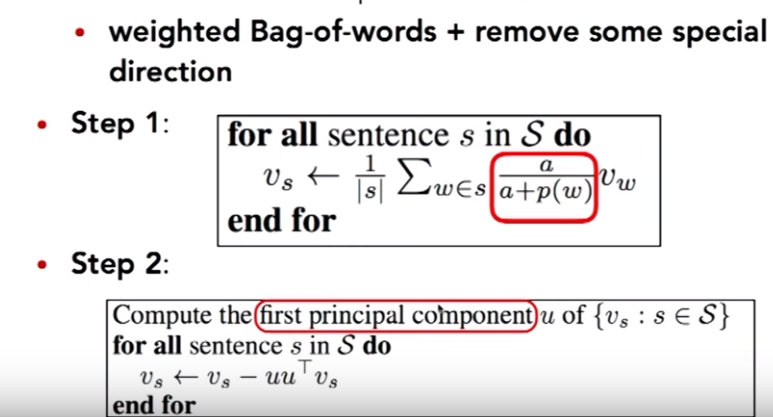

### 3.1.1. Frequency weighting 
$V_s←\frac{1}{|s|}∑_{w∈s}\frac{a}{a+p(w)}V_w$

#### 3.1.1.1. Get p(w)

In [66]:
!wget https://github.com/flying-bear/modeling_schizo/blob/master/word_freq.zip?raw=true -O word_freq.zip
!unzip word_freq.zip

--2021-02-20 17:15:15--  https://github.com/flying-bear/modeling_schizo/blob/master/word_freq.zip?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/flying-bear/modeling_schizo/raw/master/word_freq.zip [following]
--2021-02-20 17:15:15--  https://github.com/flying-bear/modeling_schizo/raw/master/word_freq.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/flying-bear/modeling_schizo/master/word_freq.zip [following]
--2021-02-20 17:15:15--  https://raw.githubusercontent.com/flying-bear/modeling_schizo/master/word_freq.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connecte

In [67]:
with open('word_freq.pickle', 'rb') as f:  # From General Internet-Corpus of Russian
  word_freq = pickle.load(f)

In [68]:
corpus_size = sum(word_freq.values()) 
corpus_size

1296570215

In [69]:
def prob(counter, word, corpus_size):
  return counter[word]/ (corpus_size)

In [70]:
freqs = {word:prob(word_freq, word, corpus_size) for word in word_freq}

In [71]:
freqs['я']

0.01033947552157829

In [72]:
def smooth(freq, a=10e-3):
  return a / (a + freq)

In [73]:
smooth(freqs['я'])

0.49165476215898146

In [74]:
smooth(freqs['тоска'])

0.9972893505037748

In [75]:
placeholder_freq = np.median(list(word_freq.values()))/corpus_size

In [76]:
smooth(placeholder_freq)

0.9999999228734463

In [77]:
def get_smooth_freq(word, a=10e-3):
  """
  gets smoothed word frequency with factor a
  uses median word frequency for words not in the frquency dictionary
  !!! uses global freqs, placeholder_freq

  :input word: str, word
  :input a: float, smoothing factor, optional, default=10e-3
  :return: float, smoothed frequency
  """
  if word in freqs:
    return smooth(freqs[word], a)
  else: 
    return smooth(placeholder_freq, a)

In [78]:
get_smooth_freq('lakwd')  # OOV

0.9999999228734463

In [79]:
get_smooth_freq('ты')  # normal word

0.8200590073396619

#### 3.1.1.2. Get weigthed average

In [80]:
def get_weighted_vector(sent, vectorization_function, a=10e-3):
  """
  Get weighted sentence average vectors
  !!! uses global get_smooth_freq

  :param sent: lsit of str, sentence to vectorize
  :param vectorization_function: function list of str -> np.array of shape (len(sent), emb_dim), preprocessing and word embedding function
  :param a: float, smoothing factor, optional, default=10e-3
  :return: np.array of shape (emb_dim,)
  """
  word_weighting_factors = [get_smooth_freq(word, a) for word in sent]
  word_vectors = vectorization_function(sent)
  return np.average(word_vectors, axis=0, weights=word_weighting_factors)

In [81]:
get_weighted_vector(ex_text, get_word_vectors_fasttext)

array([-1.47485595e-01, -8.67006271e-01, -1.01609221e+00,  1.57672720e+00,
        1.51358305e+00, -4.89849837e-01, -8.88345451e-01,  5.42566974e-01,
       -5.70711476e-01, -1.63396349e+00, -2.18372155e+00, -4.66981947e-02,
        1.09475145e-01,  1.93260146e+00,  6.08368016e-01,  4.69195994e-02,
       -1.44835695e+00,  4.93457097e-01, -3.26809432e-01,  1.99884276e+00,
       -4.73730233e-02, -1.72101858e-02, -1.16300356e+00, -1.86202222e+00,
       -1.35484105e+00,  5.13130717e-01,  3.39995588e+00, -3.38948835e-01,
       -8.48306382e-01,  4.81099119e-01, -7.47483616e-01,  1.52480650e+00,
       -1.74028216e-01, -4.66929952e-01, -2.86649253e-01, -1.67933978e+00,
       -3.14531792e-01, -5.48454602e-02, -2.13016177e+00, -1.63950410e+00,
        3.25825403e-01, -7.96472488e-01,  1.08332243e-01, -8.88853588e-01,
       -7.15274882e-01, -1.22534718e+00,  8.06013571e-01,  3.29049012e+00,
        3.35970842e-03, -2.93784163e-01, -3.39220916e-01, -5.59914806e-01,
       -7.92345036e-01, -

In [82]:
def get_weighted_vector_batch(batch, batch_vectorization_function, a=10e-3):
  """
  get weighted sentence average vectors
  !!! uses global get_smooth_freq

  :param batch: list of lsit of str, sentence to vectorize
  :param batch_vectorization_function: function list list of str -> np.array of shape (max(len(sent)), emb_dim), preprocessing and word embedding function
  :param a: float, smoothing factor, optional, default=10e-3
  :return: np.array of shape (len(batch), emb_dim,)
  """
  word_weighting_factors = [[get_smooth_freq(word, a) for word in sent] for sent in batch]
  sent_vectors = batch_vectorization_function(batch)
  batch = []
  for i, sent in enumerate(sent_vectors):
    sent = sent[:len(word_weighting_factors[i])]  # remove padding
    batch.append(np.average(sent, axis=0, weights=word_weighting_factors[i]))
  return np.stack(batch)

In [83]:
def get_weighted_vector_batch_from_vectors(batch, sent_vectors, a=10e-3):
  """
  get weighted sentence average vectors
  !!! uses global get_smooth_freq

  :param batch: list of lsit of str, sentence to vectorize
  :param sent_vectors: np.array of shape (max(len(sent)), emb_dim), word embeddings function
  :param a: float, smoothing factor, optional, default=10e-3
  :return: np.array of shape (len(batch), emb_dim,)
  """
  word_weighting_factors = [[get_smooth_freq(word, a) for word in sent] for sent in batch]
  batch = []
  for i, sent in enumerate(sent_vectors):
    sent = sent[:len(word_weighting_factors[i])]  # remove padding
    batch.append(np.average(sent, axis=0, weights=word_weighting_factors[i]))
  return np.stack(batch)

In [84]:
ex_weighted_batch = get_weighted_vector_batch([['я', 'хочу', 'спать'], ['я']], get_word_vectors_elmo_batch)

2021-02-20 17:15:39,006 : INFO : Warming up ELMo on 2 sentences...
2021-02-20 17:15:39,625 : INFO : Warming up finished.
2021-02-20 17:15:39,627 : INFO : Texts in the current batch: 2


In [85]:
 ex_weighted_batch.shape

(2, 1024)

### 3.1.2. Principle component removal

In [86]:
def compute_pc(X, npc=1):
    """
    Computes the principal components. DOES NOT MAKE THE DATA ZERO MEAN!

    :param X: np.ndarray of shape (len(sent), emb_dim), X[i,:] is a data point
    :param npc: int > 0, number of principal components to compute, optional, default 1
    :return: np.ndarray of shape (npc, emb_dim), component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1, pc=None):
    """
    Removes the projection on the principal components

    :param X: np.ndarray of shape (len(sent), emb_dim), X[i,:] is a data point
    :param npc: int > 0, number of principal components to remove, optional, default 1
    :param pc: np.ndarray of shape (1, emb_dim), optional, default None
    :return: np.ndarray of shape (len(sent), emb_dim), X[i,:], XX[i, :] is the data point after removing its projection
    """
    if pc is None:
      pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [87]:
x = np.random.rand(1,200)
print(f'shape of compute_pc:\nx: {x.shape}\ncompute_pc(x, 2): {compute_pc(x, 2).shape}')
print()
print(f'shape does not chage after removal:\nbefore: {x.shape}\nafter: {remove_pc(x, 2).shape}')

shape of compute_pc:
x: (1, 200)
compute_pc(x, 2): (1, 200)

shape does not chage after removal:
before: (1, 200)
after: (1, 200)


/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/truncated_svd.py:192: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


We need to use some common component, which will consist of combined train sets of all the tasks

In [88]:
all_train_sent = flatten([s for s, l in paraphraser['train']]) + flatten([s for s, l in XNLI['train']])

In [89]:
all_train_sent = [tokenize(s) for s in all_train_sent]

In [90]:
# all_fasttext_vect = [get_weighted_vector(s, get_word_vectors_fasttext) for s in all_train_sent]
# fasttext_pc_to_remove = compute_pc(np.array(all_fasttext_vect))
# with open('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/fc.pikle', 'wb') as f:
#   pickle.dump(fasttext_pc_to_remove, f)

In [91]:
with open('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/fc.pikle', 'rb') as f:
  fasttext_pc_to_remove = pickle.load(f)

In [92]:
# all_skipgram_vect = [get_weighted_vector(s, get_word_vectors_skipgram) for s in all_train_sent]
# skipgram_pc_to_remove = compute_pc(np.array(all_skipgram_vect))
# with open('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/sk.pikle', 'wb') as f:
#   pickle.dump(skipgram_pc_to_remove, f)

In [93]:
with open('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/sk.pikle', 'rb') as f:
  skipgram_pc_to_remove = pickle.load(f)

In [94]:
# elmo_bs = []
# batch_size = 1000
# for i in range(len(all_train_sent)//batch_size):
#   mystem_analyzer = Mystem()
#   if (i+1) * batch_size < len(all_train_sent):
#     elmo_bs.append(get_weighted_vector_batch(all_train_sent[i*batch_size: (i+1) * batch_size], get_word_vectors_elmo_batch))
#   else:
#     elmo_bs.append(get_weighted_vector_batch(all_train_sent[i*batch_size:], get_word_vectors_elmo_batch))

# with open('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/el_b1.pikle', 'wb') as f:
#   pickle.dump(elmo_bs, f)

In [95]:
with open('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/el_b1.pikle', 'rb') as f:
  elmo_bs = pickle.load(f)

In [96]:
np.concatenate(elmo_bs).shape

(20384, 1024)

In [97]:
compute_pc(np.concatenate(elmo_bs))

array([[-0.02249405, -0.01140614, -0.04854422, ...,  0.03363734,
        -0.0612299 , -0.01520186]])

In [98]:
elmo_pc_to_remove = compute_pc(np.concatenate(elmo_bs))
with open('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/el.pikle', 'wb') as f:
  pickle.dump(elmo_pc_to_remove, f)

In [99]:
def SIF(sentence, vectorization_function, pc_vector, a=10e-3):
  """
  Compute smooth inverse frequency of a sentence given a vectorization model
  !!! uses global get_weighted_vector and remove_pc

  :param sentence: list of str, sentence
  :param vectorization_function: function list of str -> np.array of shape (len(sent), emb_dim), preprocessing and word embedding function
  :param pc_vector: np.array of shape (1, emb_dim), principal component to remove
  :param a: float, smoothing factor, optional, default=10e-3
  :return: np.array of shape (emb_dim,), sentence vector
  """
  weighted = get_weighted_vector(sentence, vectorization_function, a=a)
  return remove_pc(weighted.reshape(1, -1), pc=pc_vector).squeeze()

In [100]:
ex_w = get_weighted_vector(ex_text, get_word_vectors_fasttext)
remove_pc(ex_w.reshape(1, -1), 1, pc=fasttext_pc_to_remove).squeeze()

array([ 3.37665709e-01, -1.09491464e+00, -2.05150879e-01,  2.09754067e+00,
        1.38353389e+00,  1.78544250e-02, -5.97146242e-01,  1.01613111e+00,
       -4.93344449e-01, -8.89836506e-01, -1.26930079e+00,  1.69768934e-01,
        2.45361063e-01,  1.24594263e+00, -3.83123930e-03, -3.77703871e-01,
       -1.06434261e+00, -4.18035882e-01, -1.12084878e+00,  1.65732443e+00,
       -8.09073217e-01, -6.63554711e-01, -1.33802721e+00, -1.01035600e+00,
       -1.16790726e+00,  4.89718246e-01,  2.15444900e+00, -9.59247429e-01,
       -3.02371065e-01,  8.58117021e-01,  2.98205731e-01,  1.67463347e+00,
       -7.44100021e-01, -2.77560045e-01, -5.67833156e-01, -1.21222762e+00,
       -1.27099683e+00, -2.58968770e-01, -2.07501456e+00, -2.74993129e-01,
       -5.85945984e-01, -1.39672644e-01, -5.52545795e-03, -6.07166730e-01,
       -1.35741147e-01, -2.14405501e+00,  1.37289740e-01,  3.24631490e+00,
        4.32806853e-01, -5.08566568e-01, -7.78365606e-01,  1.51934799e-01,
       -1.10156559e+00, -

In [101]:
SIF(ex_text, get_word_vectors_fasttext, fasttext_pc_to_remove).shape

(300,)

## 3.2 CPM

### 3.2.1. Power Mean
$\left(\frac{x^p_1 + \dots + x^p_n}{n} \right)^{1/p}; p \in \mathbb{R} \cup {\pm \infty}$

"We chose several intuitive values for power mean in addition to the ones already tried out, namely p = −1 (harmonic mean), p = 0.5, p = 2 (quadratic mean), and p = 3 (cubic mean). Table 4 reports the average performances over all tasks. We notice that p = 3 is the most effective power mean here and p = −1 is (by far) least effective. We discuss below why p = −1 hurts performances in this case."

In [102]:
def get_power_mean(word_vectors, powers=[3.0]):
  """
  Compute the power mean of a list of vectors

  :param word_vectors: np.array of shape(len_sent, emb_dim)
  :param powers: list of non-zero float or {'inf', '-inf'}, powers, optional, default=[3.0]
  :return: np.array of shape(emb_dim*len(power))
  """
  ps = []
  for p in powers:
    if p == 'inf':
      ps.append(np.max(word_vectors, axis=0))
    elif p == '-inf':
      ps.append(np.min(word_vectors, axis=0))     
    elif type(p) == float or type(p) == int:
      # pow = word_vectors ** p 
      # sum = np.sum(pow, axis = 0) / pow.shape[0]
      # ps.append(sum ** (1/p))
      p = float(p)
      ps.append(np.power(np.mean(np.power(np.array(word_vectors, dtype=complex), p), axis=0), 1/p).real)
    else:
      print(p)
  if len(ps) == 1:
    return ps[0]
  return np.concatenate(ps)

In [103]:
get_power_mean(get_word_vectors_fasttext(ex_text), powers=[0.5, 3, 'inf']).shape

(900,)

### 3.2.2. Concatenate from different methods
$s^{(i)} = H_{p1}(W^{(i)})\oplus \dots \oplus H_{pK}(W^{(i)})$

In [104]:
def CPM(sentence, vectorization_functions, powers):
  """
  Compute concatenated power mean representation of a sentence given several vectorization models
  !!! uses global get_power_mean
  
  :param sentence: list of str, sentence
  :param vectorization_functions: list of functions list of str -> np.array of shape (len(sent), emb_dim), preprocessing and word embedding function
  :param powers: list of non-zero float or {'inf', '-inf'}, powers
  """
  representations = [s2w(sentence) for s2w in vectorization_functions]
  power_representations = [get_power_mean(representation, powers=powers) for representation in representations]
  return np.concatenate(power_representations)

In [150]:
def CPM_from_vectors(representations, powers):
  """
  Compute concatenated power mean representation of a sentence given sentences vectorized with different methods
  !!! uses global get_power_mean
  
  :param representations: list of np.array of shape (len(sent), emb_dim), word embeddings of different methods
  :param powers: list of non-zero float or {'inf', '-inf'}, powers
  """
  power_representations = [get_power_mean(representation, powers=powers) for representation in representations]
  return np.concatenate(power_representations)

In [105]:
CPM(ex_text, [get_word_vectors_fasttext, get_word_vectors_skipgram], [2, 'inf']).shape

(1200,)

# 4. MSR Evaluation

**pipleine**:

tokenize -> vectorize -> predict -> evaluate



The [description](https://www.cs.york.ac.uk/semeval-2012/task6/data/uploads/datasets/train-readme.txt) of the original task.

The oficial score is based on Pearson correlation. 

<br>

**Gold Standard**

The gold standard contains a score between 0 and 5 for each pair of
sentences, with the following interpretation:

(5) The two sentences are completely equivalent, as they mean the same
    thing.  

      The bird is bathing in the sink.  
      Birdie is washing itself in the water basin.

(4) The two sentences are mostly equivalent, but some unimportant
    details differ.

      In May 2010, the troops attempted to invade Kabul.
      The US army invaded Kabul on May 7th last year, 2010.

(3) The two sentences are roughly equivalent, but some important
    information differs/missing.

      John said he is considered a witness but not a suspect.
      "He is not a suspect anymore." John said.

(2) The two sentences are not equivalent, but share some details.

      They flew out of the nest in groups.
      They flew into the nest together.

(1) The two sentences are not equivalent, but are on the same topic.

      The woman is playing the violin.
      The young lady enjoys listening to the guitar.

(0) The two sentences are on different topics.

      John went horse back riding at dawn with a whole group of friends.
      Sunrise at dawn is a magnificent view to take in if you wake up
      early enough for it.


In [106]:
tokenized_STS = [[tokenize(s) for s in pair[0]] for pair in STS['test']]

In [107]:
STS_target = [pair[1] for pair in STS['test']]

In [108]:
!pip install pandas --upgrade

     |████████████████████████████████| 9.5 MB 4.9 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 0.23.1
    Uninstalling pandas-0.23.1:
      Successfully uninstalled pandas-0.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
fbprophet 0.7.1 requires tqdm>=4.36.1, but you have tqdm 4.23.4 which is incompatible.
deeppavloveval 0.1 requires gensim==2.3.0, but you have gensim 3.8.0 which is incompatible.
deeppavlov 0.4.0 requires h5py==2.8.0, but you have h5py 2.10.0 which is incompatible.
deeppavlov 0.4.0 requires numpy==1.14.5, but you have numpy 1.19.5 which is incompatible.
deeppavlov 0.4.0 requires pandas==0.23.1, but you have pandas 1.1.5 which

In [184]:
import pandas as pd
mystem_analyzer = Mystem() 

In [132]:
res_columns = ['method', 'vectors', 'SIF_a', 'CPM_powers', 'pearson_r', 'pearson_p']
res_df = pd.DataFrame(columns=res_columns)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p


### 4.1. Test across SIF methods

#### 4.1.1. Fasttext

In [133]:
# a=10e-2
fasttext_pred =[cos_sim(*[SIF(s, get_word_vectors_fasttext, fasttext_pc_to_remove, a=10e-2) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fasttext_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'fasttext', 10e-2, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1,NaN,0.715789,9.138716e-119


In [134]:
# a=10e-3
fasttext_pred =[cos_sim(*[SIF(s, get_word_vectors_fasttext, fasttext_pc_to_remove) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fasttext_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'fasttext', 10e-3, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.10,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.01,NaN,0.730136,7.780063e-126


In [135]:
# a=10e-4
fasttext_pred =[cos_sim(*[SIF(s, get_word_vectors_fasttext, fasttext_pc_to_remove, a=10e-4) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fasttext_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'fasttext', 10e-4, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.100,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.010,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.001,NaN,0.748385,1.629812e-135


In [136]:
# a=10e-5
fasttext_pred =[cos_sim(*[SIF(s, get_word_vectors_fasttext, fasttext_pc_to_remove, a=10e-5) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fasttext_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'fasttext', 10e-5, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129


#### 4.1.2. SkipGram

In [137]:
# a=10e-2
skipgram_pred =[cos_sim(*[SIF(s, get_word_vectors_skipgram, skipgram_pc_to_remove, a=10e-2) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(skipgram_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'skipgram', 10e-2, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143


In [138]:
# a=10e-3
skipgram_pred =[cos_sim(*[SIF(s, get_word_vectors_skipgram, skipgram_pc_to_remove, a=10e-3) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(skipgram_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'skipgram', 10e-3, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143


In [139]:
# a=10e-4
skipgram_pred =[cos_sim(*[SIF(s, get_word_vectors_skipgram, skipgram_pc_to_remove, a=10e-4) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(skipgram_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'skipgram', 10e-4, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140


In [140]:
# a=10e-5
skipgram_pred =[cos_sim(*[SIF(s, get_word_vectors_skipgram, skipgram_pc_to_remove, a=10e-5) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(skipgram_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'skipgram', 10e-5, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131


In [199]:
res_df.to_csv('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/res.csv', index=False)

#### 4.1.3 ELMo

In [136]:
res_columns = ['method', 'vectors', 'SIF_a', 'CPM_powers', 'pearson_r', 'pearson_p']
res_df = pd.read_csv('/content/drive/MyDrive/studies/Potsdam/ANLP/Project/res.csv')

In [112]:
elmo_vecs_STS_flat = get_word_vectors_elmo_batch(flatten(tokenized_STS))

2021-02-20 17:22:32,798 : INFO : Warming up ELMo on 32 sentences...
2021-02-20 17:22:34,697 : INFO : Warming up finished.
2021-02-20 17:22:34,700 : INFO : Texts in the current batch: 32
2021-02-20 17:22:36,385 : INFO : Texts in the current batch: 32
2021-02-20 17:22:38,007 : INFO : Texts in the current batch: 32
2021-02-20 17:22:39,466 : INFO : Texts in the current batch: 32
2021-02-20 17:22:40,905 : INFO : Texts in the current batch: 32
2021-02-20 17:22:42,172 : INFO : Texts in the current batch: 32
2021-02-20 17:22:43,653 : INFO : Texts in the current batch: 32
2021-02-20 17:22:45,131 : INFO : Texts in the current batch: 32
2021-02-20 17:22:46,740 : INFO : Texts in the current batch: 32
2021-02-20 17:22:48,360 : INFO : Texts in the current batch: 32
2021-02-20 17:22:49,972 : INFO : Texts in the current batch: 32
2021-02-20 17:22:51,616 : INFO : Texts in the current batch: 32
2021-02-20 17:22:53,811 : INFO : Texts in the current batch: 32
2021-02-20 17:22:55,272 : INFO : Texts in the 

In [137]:
# a=10e-2

elmo_weighted_vecs_STS_flat = get_weighted_vector_batch_from_vectors(flatten(tokenized_STS), elmo_vecs_STS_flat, a=10e-2)
elmo_SIF = np.apply_along_axis(lambda s: remove_pc(s.reshape(1, -1), pc=elmo_pc_to_remove).squeeze(), 1, elmo_weighted_vecs_STS_flat)

elmo_SIF_pairs = []
for i in range(elmo_SIF.shape[0]):
  if i % 2 == 0:
    elmo_SIF_pairs.append((elmo_SIF[i], elmo_SIF[i+1]))

elmo_pred = [cos_sim(*pair) for pair in elmo_SIF_pairs]
r, p = pearsonr(elmo_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'ELMo', 10e-2, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129


In [138]:
# a=10e-3

elmo_weighted_vecs_STS_flat = get_weighted_vector_batch_from_vectors(flatten(tokenized_STS), elmo_vecs_STS_flat, a=10e-3)
elmo_SIF = np.apply_along_axis(lambda s: remove_pc(s.reshape(1, -1), pc=elmo_pc_to_remove).squeeze(), 1, elmo_weighted_vecs_STS_flat)

elmo_SIF_pairs = []
for i in range(elmo_SIF.shape[0]):
  if i % 2 == 0:
    elmo_SIF_pairs.append((elmo_SIF[i], elmo_SIF[i+1]))

elmo_pred = [cos_sim(*pair) for pair in elmo_SIF_pairs]
r, p = pearsonr(elmo_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'ELMo', 10e-3, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [139]:
# a=10e-4

elmo_weighted_vecs_STS_flat = get_weighted_vector_batch_from_vectors(flatten(tokenized_STS), elmo_vecs_STS_flat, a=10e-4)
elmo_SIF = np.apply_along_axis(lambda s: remove_pc(s.reshape(1, -1), pc=elmo_pc_to_remove).squeeze(), 1, elmo_weighted_vecs_STS_flat)

elmo_SIF_pairs = []
for i in range(elmo_SIF.shape[0]):
  if i % 2 == 0:
    elmo_SIF_pairs.append((elmo_SIF[i], elmo_SIF[i+1]))

elmo_pred = [cos_sim(*pair) for pair in elmo_SIF_pairs]
r, p = pearsonr(elmo_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'ELMo', 10e-4, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [140]:
# a=10e-5

elmo_weighted_vecs_STS_flat = get_weighted_vector_batch_from_vectors(flatten(tokenized_STS), elmo_vecs_STS_flat, a=10e-5)
elmo_SIF = np.apply_along_axis(lambda s: remove_pc(s.reshape(1, -1), pc=elmo_pc_to_remove).squeeze(), 1, elmo_weighted_vecs_STS_flat)

elmo_SIF_pairs = []
for i in range(elmo_SIF.shape[0]):
  if i % 2 == 0:
    elmo_SIF_pairs.append((elmo_SIF[i], elmo_SIF[i+1]))

elmo_pred = [cos_sim(*pair) for pair in elmo_SIF_pairs]
r, p = pearsonr(elmo_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['SIF', 'ELMo', 10e-5, np.nan, r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


### 4.2. Test across CPM methods

#### 4.2.1 Fasttext + SkipGram

In [145]:
# 1 +- inf
fs_pred =[cos_sim(*[CPM(s, [get_word_vectors_fasttext, get_word_vectors_skipgram], [1, 'inf', '-inf']) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fs_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram', np.nan, '1, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [146]:
# 1 2 +- inf
fs_pred =[cos_sim(*[CPM(s, [get_word_vectors_fasttext, get_word_vectors_skipgram], [1, 2, 'inf', '-inf']) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fs_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram', np.nan, '1, 2, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [147]:
# 1 2 3 +- inf
fs_pred =[cos_sim(*[CPM(s, [get_word_vectors_fasttext, get_word_vectors_skipgram], [1, 2, 3, 'inf', '-inf']) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fs_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram', np.nan, '1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [148]:
# 0.5, 1 2 3 +- inf
fs_pred =[cos_sim(*[CPM(s, [get_word_vectors_fasttext, get_word_vectors_skipgram], [0.5, 1, 2, 3, 'inf', '-inf']) for s in tokenized_pair]) for tokenized_pair in tokenized_STS]
r, p = pearsonr(fs_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram', np.nan, '0.5, 1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


#### 4.2.2. Fasttext + ELMo

In [152]:
fasttext_vecs_STS_flat = [get_word_vectors_fasttext(s) for s in flatten(tokenized_STS)]

In [164]:
fe_pairs = []
for i in range(elmo_vecs_STS_flat.shape[0]):
  if i % 2 == 0:
    fe_pairs.append(([elmo_vecs_STS_flat[i], fasttext_vecs_STS_flat[i]], [elmo_vecs_STS_flat[i+1], fasttext_vecs_STS_flat[i+1]]))

In [178]:
# 1 +- inf
fe_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 'inf', '-inf'])) for  representation_pair in fe_pairs]
r, p = pearsonr(fe_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+ELMo', np.nan, '1, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [179]:
# 1 2 +- inf
fe_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 2, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 2, 'inf', '-inf'])) for  representation_pair in fe_pairs]
r, p = pearsonr(fe_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+ELMo', np.nan, '1, 2, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [180]:
# 1 2 3 +- inf
fe_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 2, 3, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 2, 3, 'inf', '-inf'])) for  representation_pair in fe_pairs]
r, p = pearsonr(fe_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+ELMo', np.nan, '1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [181]:
# 0.5 1 2 3 +- inf
fe_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [0.5, 1, 2, 3, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [0.5, 1, 2, 3, 'inf', '-inf'])) for  representation_pair in fe_pairs]
r, p = pearsonr(fe_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+ELMo', np.nan, '0.5, 1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


#### 4.2.3 SkipGram + ELMo

In [185]:
skipgram_vecs_STS_flat = [get_word_vectors_skipgram(s) for s in flatten(tokenized_STS)]

In [186]:
se_pairs = []
for i in range(elmo_vecs_STS_flat.shape[0]):
  if i % 2 == 0:
    se_pairs.append(([elmo_vecs_STS_flat[i], skipgram_vecs_STS_flat[i]], [elmo_vecs_STS_flat[i+1], skipgram_vecs_STS_flat[i+1]]))

In [189]:
# 1 +- inf
se_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 'inf', '-inf'])) for  representation_pair in se_pairs]
r, p = pearsonr(se_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'skipgram+ELMo', np.nan, '1, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [190]:
# 1 2 +- inf
se_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 2, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 2, 'inf', '-inf'])) for  representation_pair in se_pairs]
r, p = pearsonr(se_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'skipgram+ELMo', np.nan, '1, 2, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [191]:
# 1 2 3 +- inf
se_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 2, 3, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 2, 3, 'inf', '-inf'])) for  representation_pair in se_pairs]
r, p = pearsonr(se_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'skipgram+ELMo', np.nan, '1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [192]:
# 0.5 1 2 3 +- inf
se_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [0.5, 1, 2, 3, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [0.5, 1, 2, 3, 'inf', '-inf'])) for  representation_pair in se_pairs]
r, p = pearsonr(se_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'skipgram+ELMo', np.nan, '0.5, 1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


#### 4.2.4 Fasttext + SkipGram + ELMo

In [193]:
fse_pairs = []
for i in range(elmo_vecs_STS_flat.shape[0]):
  if i % 2 == 0:
    fse_pairs.append(([elmo_vecs_STS_flat[i], skipgram_vecs_STS_flat[i], fasttext_vecs_STS_flat[i]], [elmo_vecs_STS_flat[i+1], skipgram_vecs_STS_flat[i+1], fasttext_vecs_STS_flat[i+1]]))

In [194]:
# 1 +- inf
fse_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 'inf', '-inf'])) for  representation_pair in fse_pairs]
r, p = pearsonr(fse_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram+ELMo', np.nan, '1, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [196]:
# 1 2 +- inf
fse_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 2, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 2, 'inf', '-inf'])) for  representation_pair in fse_pairs]
r, p = pearsonr(fse_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram+ELMo', np.nan, '1, 2, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [197]:
# 1 2 3 +- inf
fse_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [1, 2, 3, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [1, 2, 3, 'inf', '-inf'])) for  representation_pair in fse_pairs]
r, p = pearsonr(fse_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram+ELMo', np.nan, '1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


In [198]:
# 0.5 1 2 3 +- inf
fse_pred = [cos_sim(CPM_from_vectors(representation_pair[0], [0.5, 1, 2, 3, 'inf', '-inf']), CPM_from_vectors(representation_pair[1], [0.5, 1, 2, 3, 'inf', '-inf'])) for  representation_pair in fse_pairs]
r, p = pearsonr(fse_pred, STS_target)
res_df = res_df.append(pd.DataFrame([['CPM', 'fasttext+skipgram+ELMo', np.nan, '0.5, 1, 2, 3, inf, -inf', r, p]], columns=res_columns), ignore_index=True)
res_df

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p
0,SIF,fasttext,0.1000,NaN,0.715789,9.138716e-119
1,SIF,fasttext,0.0100,NaN,0.730136,7.780063e-126
2,SIF,fasttext,0.0010,NaN,0.748385,1.629812e-135
3,SIF,fasttext,0.0001,NaN,0.737164,1.816586e-129
4,SIF,skipgram,0.1000,NaN,0.762348,1.669354e-143
5,SIF,skipgram,0.0100,NaN,0.762406,1.543852e-143
6,SIF,skipgram,0.0010,NaN,0.757371,1.356280e-140
7,SIF,skipgram,0.0001,NaN,0.740220,4.401062e-131
8,SIF,ELMo,0.1000,NaN,0.736663,3.329499e-129
9,SIF,ELMo,0.0100,NaN,0.739083,1.766553e-130


## 4.3 Results

In [220]:
res_df.sort_values(['pearson_r'], ascending=False).style.background_gradient(axis=0, cmap='Reds')

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p,sig
5,SIF,skipgram,0.010000,nan,0.762406,0.000000,True
4,SIF,skipgram,0.100000,nan,0.762348,0.000000,True
6,SIF,skipgram,0.001000,nan,0.757371,0.000000,True
2,SIF,fasttext,0.001000,nan,0.748385,0.000000,True
10,SIF,ELMo,0.001000,nan,0.743325,0.000000,True
7,SIF,skipgram,0.000100,nan,0.740220,0.000000,True
9,SIF,ELMo,0.010000,nan,0.739083,0.000000,True
3,SIF,fasttext,0.000100,nan,0.737164,0.000000,True
11,SIF,ELMo,0.000100,nan,0.736762,0.000000,True
8,SIF,ELMo,0.100000,nan,0.736663,0.000000,True


In [222]:
np.mean(res_df[res_df['method'] == 'SIF']['pearson_r']) > np.mean(res_df[res_df['method'] == 'CPM']['pearson_r'])

True

SIF is better than CPM in general

In [219]:
res_df[res_df['method'] == 'SIF'].sort_values(['pearson_r'], ascending=False).style.background_gradient(axis=0, cmap='Reds')

,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p,sig
5,SIF,skipgram,0.010000,nan,0.762406,0.000000,True
4,SIF,skipgram,0.100000,nan,0.762348,0.000000,True
6,SIF,skipgram,0.001000,nan,0.757371,0.000000,True
2,SIF,fasttext,0.001000,nan,0.748385,0.000000,True
10,SIF,ELMo,0.001000,nan,0.743325,0.000000,True
7,SIF,skipgram,0.000100,nan,0.740220,0.000000,True
9,SIF,ELMo,0.010000,nan,0.739083,0.000000,True
3,SIF,fasttext,0.000100,nan,0.737164,0.000000,True
11,SIF,ELMo,0.000100,nan,0.736762,0.000000,True
8,SIF,ELMo,0.100000,nan,0.736663,0.000000,True


In [232]:
np.mean(res_df[res_df['method'] == 'SIF'][res_df['vectors'] == 'skipgram']['pearson_r']) > np.mean(res_df[res_df['method'] == 'SIF'][res_df['vectors'] == 'ELMo']['pearson_r'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


True

In [233]:
np.mean(res_df[res_df['method'] == 'SIF'][res_df['vectors'] == 'skipgram']['pearson_r']) > np.mean(res_df[res_df['method'] == 'SIF'][res_df['vectors'] == 'fasttext']['pearson_r'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


True

In [234]:
np.mean(res_df[res_df['method'] == 'SIF'][res_df['vectors'] == 'ELMo']['pearson_r']) > np.mean(res_df[res_df['method'] == 'SIF'][res_df['vectors'] == 'fasttext']['pearson_r'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


True

skipgram > ELMo > fasttext \\
within the method a=10e-4 and  a=10e-3 are the best, just as reported in the original article

In [218]:
res_df[res_df['method'] == 'CPM'].sort_values(['pearson_r'], ascending=False).style.background_gradient(axis=0, cmap='Reds')

/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.6/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,method,vectors,SIF_a,CPM_powers,pearson_r,pearson_p,sig
22,CPM,skipgram+ELMo,nan,"1, 2, 3, inf, -inf",0.730366,0.000000,True
23,CPM,skipgram+ELMo,nan,"0.5, 1, 2, 3, inf, -inf",0.729749,0.000000,True
21,CPM,skipgram+ELMo,nan,"1, 2, inf, -inf",0.729293,0.000000,True
20,CPM,skipgram+ELMo,nan,"1, inf, -inf",0.729254,0.000000,True
27,CPM,fasttext+skipgram+ELMo,nan,"0.5, 1, 2, 3, inf, -inf",0.678724,0.000000,True
19,CPM,fasttext+ELMo,nan,"0.5, 1, 2, 3, inf, -inf",0.677663,0.000000,True
26,CPM,fasttext+skipgram+ELMo,nan,"1, 2, 3, inf, -inf",0.675292,0.000000,True
18,CPM,fasttext+ELMo,nan,"1, 2, 3, inf, -inf",0.674145,0.000000,True
15,CPM,fasttext+skipgram,nan,"0.5, 1, 2, 3, inf, -inf",0.673378,0.000000,True
25,CPM,fasttext+skipgram+ELMo,nan,"1, 2, inf, -inf",0.672416,0.000000,True


In [238]:
np.mean(res_df[res_df['vectors'] == 'fasttext+skipgram+ELMo']['pearson_r']) > np.mean(res_df[res_df['vectors'] == 'fasttext+ELMo']['pearson_r'])

True

In [239]:
np.mean(res_df[res_df['vectors'] == 'fasttext+ELMo']['pearson_r']) > np.mean(res_df[res_df['vectors'] == 'fasttext+skipgram']['pearson_r'])

True

skipgram+ELMo > fasttext+skipgram+ELMo > fasttext+ELMo > fasttext+skipgram

In [240]:
np.mean(res_df[res_df['CPM_powers'] == '0.5, 1, 2, 3, inf, -inf']['pearson_r']) > np.mean(res_df[res_df['CPM_powers'] == '1, 2, 3, inf, -inf']['pearson_r'])

True

In [241]:
np.mean(res_df[res_df['CPM_powers'] == '1, 2, 3, inf, -inf']['pearson_r']) > np.mean(res_df[res_df['CPM_powers'] == '1, 2, inf, -inf']['pearson_r'])

True

In [242]:
np.mean(res_df[res_df['CPM_powers'] == '1, 2, inf, -inf']['pearson_r']) > np.mean(res_df[res_df['CPM_powers'] == '1, inf, -inf']['pearson_r'])

True

more powers is better but not directly significantly so

In [250]:
pearsonr(res_df[res_df['method'] == 'CPM']['CPM_powers'].apply(lambda x: len(x.split()) - 2), res_df[res_df['method'] == 'CPM']['pearson_r'])

(0.11935434518207076, 0.6597415795563155)